In [1]:
import torchvision as tv
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
show = ToPILImage() # 可以把Tensor转成Image，方便可视化

In [2]:
transform = transforms.Compose([
        transforms.ToTensor(), # 转为Tensor
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # 归一化
                             ])

In [3]:
trainset = tv.datasets.CIFAR10(
                    root='/Users/mac/Downloads/data2', 
                    train=True, 
                    download=True,
                    transform=transform)


In [5]:
import torch as t

In [6]:
trainloader = t.utils.data.DataLoader(
                    trainset, 
                    batch_size=4,
                    shuffle=True, 
                    num_workers=2)


In [7]:
testset = tv.datasets.CIFAR10(
                    '/Users/mac/Downloads/data2',
                    train=False, 
                    download=True, 
                    transform=transform)

testloader = t.utils.data.DataLoader(
                    testset,
                    batch_size=4, 
                    shuffle=False,
                    num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified


ship


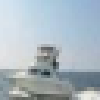

In [8]:
(data, label) = trainset[100]
print(classes[label])

# (data + 1) / 2是为了还原被归一化的数据
show((data + 1) / 2).resize((100, 100))


      truck        deer         dog       horse


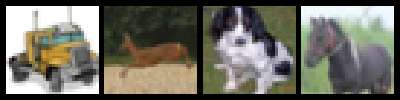

In [9]:
dataiter = iter(trainloader)
images, labels = dataiter.next() # 返回4张图片及标签
print(' '.join('%11s'%classes[labels[j]] for j in range(4)))
show(tv.utils.make_grid((images+1)/2)).resize((400,100))

In [10]:
import torch.nn as nn
import torch.nn.functional as F

In [21]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) 
        self.conv2 = nn.Conv2d(6, 16, 5)  
        self.fc1   = nn.Linear(16*5*5, 120)  
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x): 
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2)) 
        x = F.max_pool2d(F.relu(self.conv2(x)), 2) 
        x = x.view(x.size()[0], -1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)        
        return x


net = Net()
print(net)


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [22]:
from torch import optim
criterion = nn.CrossEntropyLoss() # 交叉熵损失函数
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [24]:
t.set_num_threads(8)

for epoch in range(2):
    running_loss = 0.0
    for i,data in enumerate(trainloader,0):
        inputs,labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i%2000 == 1999:
            print('[%d, %5d] loss: %.3f' \
                  % (epoch+1, i+1, running_loss / 2000))
            running_loss = 0.0
print('Finished Training')


[1,  2000] loss: 2.196
[1,  4000] loss: 1.859
[1,  6000] loss: 1.667
[1,  8000] loss: 1.571
[1, 10000] loss: 1.497
[1, 12000] loss: 1.448
[2,  2000] loss: 1.402
[2,  4000] loss: 1.363
[2,  6000] loss: 1.342
[2,  8000] loss: 1.320
[2, 10000] loss: 1.284
[2, 12000] loss: 1.255
Finished Training


实际的label:       cat     ship     ship    plane


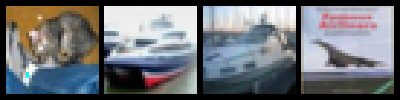

In [25]:
dataiter = iter(testloader)
images, labels = dataiter.next() # 一个batch返回4张图片
print('实际的label: ', ' '.join(\
            '%08s'%classes[labels[j]] for j in range(4)))
show(tv.utils.make_grid(images / 2 - 0.5)).resize((400,100))


In [26]:
outputs = net(images)
# 得分最高的那个类
_, predicted = t.max(outputs.data, 1)

print('预测结果: ', ' '.join('%5s'\
            % classes[predicted[j]] for j in range(4)))


预测结果:    cat  ship  ship  ship


In [27]:
correct = 0 # 预测正确的图片数
total = 0 # 总共的图片数


# 由于测试的时候不需要求导，可以暂时关闭autograd，提高速度，节约内存
with t.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = t.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

print('10000张测试集中的准确率为: %d %%' % (100 * correct / total))


10000张测试集中的准确率为: 55 %
